##### Copyright 2021 The TensorFlow Probability Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFP 版本说明笔记本 (0.13.0)

此笔记本旨在使用一些小代码段（小型化演示您可以使用 TFP 实现的内容）让 TFP 0.13.0 看起来“栩栩如生”。

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/probability/examples/TFP_Release_Notebook_0_13_0"><img src="https://tensorflow.google.cn/images/tf_logo_32px.png">在 TensorFlow.org上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行</a></td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/probability/examples/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 Github 上查看源代码</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/probability/examples/TFP_Release_Notebook_0_13_0.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a>   </td>
</table>

In [1]:
#@title Installs & imports { vertical-output: true }
!pip3 install -qU tensorflow==2.5.0 tensorflow_probability==0.13.0 tensorflow-datasets inference_gym

import tensorflow as tf
import tensorflow_probability as tfp
assert '0.13' in tfp.__version__, tfp.__version__
assert '2.5' in tf.__version__, tf.__version__

physical_devices = tf.config.list_physical_devices('CPU')
tf.config.set_logical_device_configuration(
    physical_devices[0],
    [tf.config.LogicalDeviceConfiguration(),
     tf.config.LogicalDeviceConfiguration()])

tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import IPython
import seaborn as sns
import logging

     |████████████████████████████████| 5.4MB 8.8MB/s 
     |████████████████████████████████| 3.9MB 37.1MB/s 
     |████████████████████████████████| 296kB 31.6MB/s 


## 分布 [核心数学]

### `BetaQuotient`

两个独立的 Beta 分布随机变量的比值

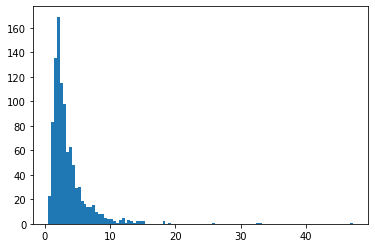

In [2]:
plt.hist(tfd.BetaQuotient(concentration1_numerator=5.,
                          concentration0_numerator=2.,
                          concentration1_denominator=3.,
                          concentration0_denominator=8.).sample(1_000, seed=(1, 23)),
         bins='auto');

### `DeterminantalPointProcess`

给定集合的子集（表示为独热码）上的分布。样本遵循排斥特性（概率与对应于选定点子集的矢量所跨越的量成比例），这倾向于对不同的子集进行采样。[与 i.i.d. Bernoulli 样本进行比较。]

tfp.distributions.DeterminantalPointProcess("DeterminantalPointProcess", batch_shape=[4], event_shape=[256], dtype=int32)


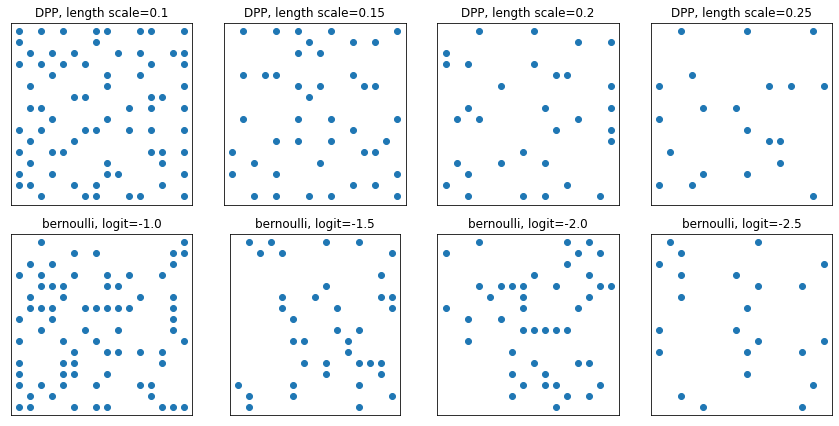

In [3]:
grid_size = 16
# Generate grid_size**2 pts on the unit square.
grid = np.arange(0, 1, 1./grid_size).astype(np.float32)
import itertools
points = np.array(list(itertools.product(grid, grid)))

# Create the kernel L that parameterizes the DPP.
kernel_amplitude = 2.
kernel_lengthscale = [.1, .15, .2, .25]  # Increasing length scale indicates more points are "nearby", tending toward smaller subsets.
kernel = tfpk.ExponentiatedQuadratic(kernel_amplitude, kernel_lengthscale)
kernel_matrix = kernel.matrix(points, points)

eigenvalues, eigenvectors = tf.linalg.eigh(kernel_matrix)
dpp = tfd.DeterminantalPointProcess(eigenvalues, eigenvectors)
print(dpp)

# The inner-most dimension of the result of `dpp.sample` is a multi-hot
# encoding of a subset of {1, ..., ground_set_size}.
# We will compare against a bernoulli distribution.
samps_dpp = dpp.sample(seed=(1, 2))  # 4 x grid_size**2
logits = tf.broadcast_to([[-1.], [-1.5], [-2], [-2.5]], [4, grid_size**2])
samps_bern = tfd.Bernoulli(logits=logits).sample(seed=(2, 3))

plt.figure(figsize=(12, 6))
for i, (samp, samp_bern) in enumerate(zip(samps_dpp, samps_bern)):
  plt.subplot(241 + i)
  plt.scatter(*points[np.where(samp)].T)
  plt.title(f'DPP, length scale={kernel_lengthscale[i]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)
  plt.subplot(241 + i + 4)
  plt.scatter(*points[np.where(samp_bern)].T)
  plt.title(f'bernoulli, logit={logits[i,0]}')
  plt.xticks([])
  plt.yticks([])
  plt.gca().set_aspect(1.)

plt.tight_layout()
plt.show()

### `SigmoidBeta`

两个伽马分布的对数几率。在数值上比 `Beta` 更稳定的样本空间。

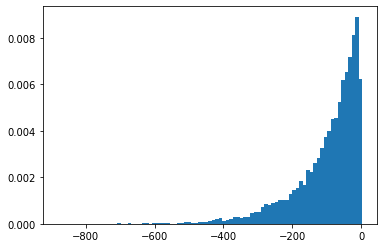

Old way, fractions non-finite:
0.4215
0.8624


In [4]:
plt.hist(tfd.SigmoidBeta(concentration1=.01, concentration0=2.).sample(10_000, seed=(1, 23)),
         bins='auto', density=True);
plt.show()

print('Old way, fractions non-finite:')
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=.01, concentration0=2.)).sample(10_000, seed=(1, 23)))) / 10_000)
print(np.sum(~tf.math.is_finite(
    tfb.Invert(tfb.Sigmoid())(tfd.Beta(concentration1=2., concentration0=.01)).sample(10_000, seed=(2, 34)))) / 10_000)

### Zipf

增加了 JAX 支持。

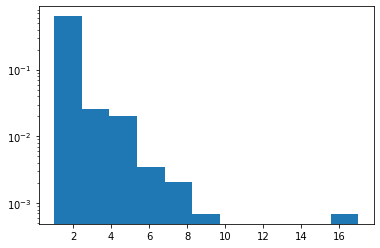

In [5]:
plt.hist(tfd.Zipf(3.).sample(1_000, seed=(12, 34)).numpy(), bins='auto', density=True, log=True);

### `NormalInverseGaussian`

灵活的参数化系列，支持重尾、倾斜和原始正态。

### `MatrixNormalLinearOperator`

矩阵正态分布。

In [6]:
# Initialize a single 2 x 3 Matrix Normal.
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixNormalLinearOperator(loc=mu, scale_row=scale_row, scale_column=scale_column)
mvn.sample()

Instructions for updating:
Do not call `graph_parents`.


<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.2495145, 1.549366 , 3.2748342],
       [3.7330258, 4.3413105, 4.83423  ]], dtype=float32)>

### `MatrixStudentTLinearOperator`

矩阵 T 分布。

In [7]:
mu = [[1., 2, 3], [3., 4, 5]]
col_cov = [[ 0.36,  0.12,  0.06],
           [ 0.12,  0.29, -0.13],
           [ 0.06, -0.13,  0.26]]
scale_column = tf.linalg.LinearOperatorLowerTriangular(tf.linalg.cholesky(col_cov))
scale_row = tf.linalg.LinearOperatorDiag([0.9, 0.8])

mvn = tfd.MatrixTLinearOperator(
    df=2.,
    loc=mu,
    scale_row=scale_row,
    scale_column=scale_column)
mvn.sample()

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1.6549466, 2.6708362, 2.8629923],
       [2.1222284, 3.6904747, 5.08014  ]], dtype=float32)>

## 分布 [软件/包装器]

### `Sharded`

将分布的独立事件部分分片到多个处理器。跨设备聚合 `log_prob`，与 `tfp.experimental.distribute.JointDistribution*` 一起处理梯度。更多信息，请参见[分布式推断](https://tensorflow.google.cn/probability/examples/Distributed_Inference_with_JAX)笔记本。

In [8]:
strategy = tf.distribute.MirroredStrategy()

@tf.function
def sample_and_lp(seed):
  d = tfp.experimental.distribute.Sharded(tfd.Normal(0, 1))
  s = d.sample(seed=seed)
  return s, d.log_prob(s)

strategy.run(sample_and_lp, args=(tf.constant([12,34]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.0051413667>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.3393052>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-1.8954543>
 })

### `BatchBroadcast`

*通过*给定批次形状或*向*给定批次形状隐式广播基础分布的批次维度。

In [9]:
underlying = tfd.MultivariateNormalDiag(tf.zeros([7, 1, 5]), tf.ones([5]))
print('underlying:', underlying)

d = tfd.BatchBroadcast(underlying, [8, 1, 6])
print('broadcast [7, 1] *with* [8, 1, 6]:', d)

try:
  tfd.BatchBroadcast(underlying, to_shape=[8, 1, 6])
except ValueError as e:
  print('broadcast [7, 1] *to* [8, 1, 6] is invalid:', e)

d = tfd.BatchBroadcast(underlying, to_shape=[8, 7, 6])
print('broadcast [7, 1] *to* [8, 7, 6]:', d)

underlying: tfp.distributions.MultivariateNormalDiag("MultivariateNormalDiag", batch_shape=[7, 1], event_shape=[5], dtype=float32)
broadcast [7, 1] *with* [8, 1, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)
broadcast [7, 1] *to* [8, 1, 6] is invalid: Argument `to_shape` ([8 1 6]) is incompatible with underlying distribution batch shape ((7, 1)).
broadcast [7, 1] *to* [8, 7, 6]: tfp.distributions.BatchBroadcast("BatchBroadcastMultivariateNormalDiag", batch_shape=[8, 7, 6], event_shape=[5], dtype=float32)


### `Masked`

对于单程序/多数据或稀疏作为掩码的密集用例，一种屏蔽了无效基础分布的 `log_prob` 的分布。

In [10]:
d = tfd.Masked(tfd.Normal(tf.zeros([7]), 1), 
               validity_mask=tf.sequence_mask([3, 4], 7))
print(d.log_prob(d.sample(seed=(1, 1))))

d = tfd.Masked(tfd.Normal(0, 1), 
               validity_mask=[False, True, False],
               safe_sample_fn=tfd.Distribution.mode)
print(d.log_prob(d.sample(seed=(2, 2))))

tf.Tensor(
[[-2.3054113 -1.8524303 -1.2220721  0.         0.         0.
   0.       ]
 [-1.118623  -1.1370811 -1.1574132 -5.884986   0.         0.
   0.       ]], shape=(2, 7), dtype=float32)
tf.Tensor([ 0.         -0.93683904  0.        ], shape=(3,), dtype=float32)


## 双射器

- 双射器
    - 为模拟 `tf.nest.flatten` (`tfb.tree_flatten`) 和 `tf.nest.pack_sequence_as` (`tfb.pack_sequence_as`) 增加双射函数。
    - 增加 `tfp.experimental.bijectors.Sharded`
    - 删除已弃用的 `tfb.ScaleTrilL`。改用 `tfb.FillScaleTriL`。
    - 为双射函数增加 `cls.parameter_properties()` 注解。
    - 将范围 `tfb.Power` 扩展到奇数整数幂的所有实数。
    - 如果没有另外指定，使用 autodiff 推断标量双射函数的 log-deg-jacobian。


### 重组双射函数

In [11]:
ex = (tf.constant(1.), dict(b=tf.constant(2.), c=tf.constant(3.)))
b = tfb.tree_flatten(ex)
print(b.forward(ex))
print(b.inverse(list(tf.constant([1., 2, 3]))))

b = tfb.pack_sequence_as(ex)
print(b.forward(list(tf.constant([1., 2, 3]))))
print(b.inverse(ex))

[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
(<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, {'b': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, 'c': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>})
[<tf.Tensor: shape=(), dtype=float32, numpy=1.0>, <tf.Tensor: shape=(), dtype=float32, numpy=2.0>, <tf.Tensor: shape=(), dtype=float32, numpy=3.0>]


### `Sharded`

对数行列式中的 SPMD 归约。请参阅下文“分布”中的 `Sharded`。

In [13]:
strategy = tf.distribute.MirroredStrategy()

def sample_lp_logdet(seed):
  d = tfd.TransformedDistribution(tfp.experimental.distribute.Sharded(tfd.Normal(0, 1), shard_axis_name='i'),
                                  tfp.experimental.bijectors.Sharded(tfb.Sigmoid(), shard_axis_name='i'))
  s = d.sample(seed=seed)
  return s, d.log_prob(s), d.bijector.inverse_log_det_jacobian(s)
strategy.run(sample_lp_logdet, (tf.constant([1, 2]),))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0', '/job:localhost/replica:0/task:0/device:CPU:1').


(PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=0.87746525>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=0.24580425>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=-0.48870325>
 }, PerReplica:{
   0: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>,
   1: <tf.Tensor: shape=(), dtype=float32, numpy=3.9154015>
 })

## VI

- 为 `tfp.experimental.vi` 增加 `build_split_flow_surrogate_posterior` 以从规范化流构建结构化 VI 代理后验。
- 为 `tfp.experimental.vi` 增加 `build_affine_surrogate_posterior` 以从事件形状构造 ADVI 代理后验。
- 为 `tfp.experimental.vi` 增加 `build_affine_surrogate_posterior_from_base_distribution`，以便能通过由仿射变换诱导的相关性结构来构造 ADVI 代理后验。


### VI/MAP/MLE

- 增加了方便的方法 `tfp.experimental.util.make_trainable(cls)`，以创建分布和双射函数的可训练实例。

In [ ]:
d = tfp.experimental.util.make_trainable(tfd.Gamma)
print(d.trainable_variables)
print(d)

(<tf.Variable 'Gamma_trainable_variables/concentration:0' shape=() dtype=float32, numpy=1.0296053>, <tf.Variable 'Gamma_trainable_variables/log_rate:0' shape=() dtype=float32, numpy=-0.3465951>)
tfp.distributions.Gamma("Gamma", batch_shape=[], event_shape=[], dtype=float32)


## 马尔科夫链蒙特卡洛法

- MCMC 诊断支持任意状态结构，而不仅仅是列表。
- 为 `tfp.experimental.mcmc` 增加了 `remc_thermodynamic_integrals`
- 增加 `tfp.experimental.mcmc.windowed_adaptive_hmc`
- 增加一个实验性 API，用于从无约束空间中接近零的均匀分布初始化马尔可夫链。 `tfp.experimental.mcmc.init_near_unconstrained_zero`
- 增加一个实验性实用程序，用于重试马尔可夫链初始化，直到找到可接受的点。 `tfp.experimental.mcmc.retry_init`
- 以最少的中断将实验性流式 MCMC API 改组以插入 tfp.mcmc。
- 为 `experimental.mcmc` 增加 `ThinningKernel`。
- 将 `experimental.mcmc.run_kernel` 驱动程序作为候选的基于流的替代品添加到 `mcmc.sample_chain`


### `init_near_unconstrained_zero`，`retry_init`

In [73]:
@tfd.JointDistributionCoroutine
def model():
  Root = tfd.JointDistributionCoroutine.Root
  c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
  c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
  counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), 10, name='counts')
jd = model.experimental_pin(counts=model.sample(seed=[20, 30]).counts)

init_dist = tfp.experimental.mcmc.init_near_unconstrained_zero(jd)
print(init_dist)

tfp.experimental.mcmc.retry_init(init_dist.sample, jd.unnormalized_log_prob)

tfp.distributions.TransformedDistribution("default_joint_bijectorrestructureJointDistributionSequential", batch_shape=StructTuple(
  c0=[],
  c1=[]
), event_shape=StructTuple(
  c0=[],
  c1=[]
), dtype=StructTuple(
  c0=float32,
  c1=float32
))


StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=1.7879653>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=0.34548905>
)

### 窗口自适应 HMC 和 NUTS 采样器

StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(10,), dtype=float32, numpy=array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17.], dtype=float32)>
)
StructTuple(
  c0=<tf.Tensor: shape=(), dtype=float32, numpy=0.7161876>,
  c1=<tf.Tensor: shape=(), dtype=float32, numpy=1.7696666>,
  counts=<tf.Tensor: shape=(250,), dtype=float32, numpy=
    array([ 6., 10., 23.,  7.,  2., 20., 14., 16., 22., 17., 22., 21.,  6.,
           21., 12., 22., 23., 16., 18., 21., 16., 17., 17., 16., 21., 14.,
           23., 15., 10., 19.,  8., 23., 23., 14.,  1., 23., 16., 22., 20.,
           20., 22., 15., 16., 20., 20., 21., 23., 22., 21., 15., 18., 23.,
           12., 16., 19., 23., 18.,  5., 22., 22., 22., 18., 12., 17., 17.,
           16.,  8., 22., 20., 23.,  3., 12., 14., 18.,  7., 19., 19.,  9.,
           10., 23., 14., 22., 22., 21., 13., 23., 14., 23., 10., 17., 23.,
           17.

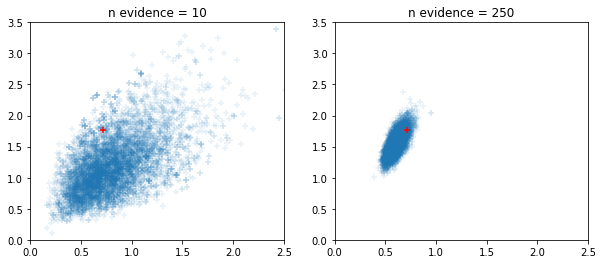

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, n_evidence in enumerate((10, 250)):
  ax[i].set_title(f'n evidence = {n_evidence}')
  ax[i].set_xlim(0, 2.5); ax[i].set_ylim(0, 3.5)
  @tfd.JointDistributionCoroutine
  def model():
    Root = tfd.JointDistributionCoroutine.Root
    c0 = yield Root(tfd.Gamma(2, 2, name='c0'))
    c1 = yield Root(tfd.Gamma(2, 2, name='c1'))
    counts = yield tfd.Sample(tfd.BetaBinomial(23, c1, c0), n_evidence, name='counts')
  s = model.sample(seed=[20, 30])
  print(s)
  jd = model.experimental_pin(counts=s.counts)
  states, trace = tf.function(tfp.experimental.mcmc.windowed_adaptive_hmc)(
      100, jd, num_leapfrog_steps=5, seed=[100, 200])
  ax[i].scatter(states.c0.numpy().reshape(-1), states.c1.numpy().reshape(-1), 
                marker='+', alpha=.1)
  ax[i].scatter(s.c0, s.c1, marker='+', color='r')

## 数学，统计

- 数学/linalg

    - 增加 `tfp.math.trapz` 以进行梯形积分。
    - 增加 `tfp.math.log_bessel_kve`。
    - 为 `experimental.linalg` 增加 `no_pivot_ldl`。
    - 为 `GaussianProcess` 增加 `marginal_fn` 参数（请参阅 `no_pivot_ldl`）。
    - 增加了 `tfp.math.atan_difference(x, y)`
    - 增加 `tfp.math.erfcx`、`tfp.math.logerfc` 和 `tfp.math.logerfcx`
    - 增加 `tfp.math.dawsn` 以实现道森积分。
    - 增加 `tfp.math.igammaincinv`、`tfp.math.igammacinv`。
    - 增加 `tfp.math.sqrt1pm1`。
    - 增加 `LogitNormal.stddev_approx` 和 `LogitNormal.variance_approx`
    - 增加 `tfp.math.owens_t` 以实现欧文 T 函数。
    - 增加 `bracket_root` 方法以自动初始化根搜索的边界。
    - 增加 Chandrupatla 的求标量函数根的方法。

- 统计

    - `tfp.stats.windowed_mean` 可有效计算窗口均值。
    - `tfp.stats.windowed_variance` 可有效准确地计算窗口方差。
    - `tfp.stats.cumulative_variance` 可有效准确地计算累积方差。
    - `RunningCovariance` 和同类函数现在可以从示例张量初始化，而不仅仅是从显式形状和 dtype。
    - 为 `RunningCentralMoments`、`RunningMean`、`RunningPotentialScaleReduction` 提供更简洁的 API。


### 欧文 T、Erfcx、Logerfc、Logerfcx、道森函数

In [ ]:
# Owen's T gives the probability that X > h, 0 < Y < a * X. Let's check that
# with random sampling.
h = np.array([1., 2.]).astype(np.float32)
a = np.array([10., 11.5]).astype(np.float32)
probs = tfp.math.owens_t(h, a)

x = tfd.Normal(0., 1.).sample(int(1e5), seed=(6, 245)).numpy()
y = tfd.Normal(0., 1.).sample(int(1e5), seed=(7, 245)).numpy()

true_values = (
    (x[..., np.newaxis] > h) &
    (0. < y[..., np.newaxis]) &
    (y[..., np.newaxis] < a * x[..., np.newaxis]))

print('Calculated values: {}'.format(
    np.count_nonzero(true_values, axis=0) / 1e5))

print('Expected values: {}'.format(probs))

Calculated values: [0.07896 0.01134]
Expected values: [0.07932763 0.01137507]


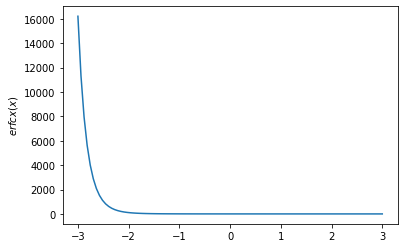

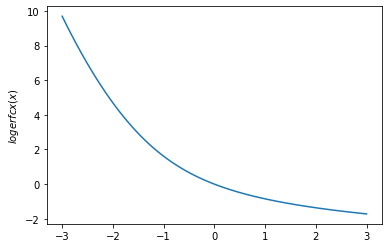

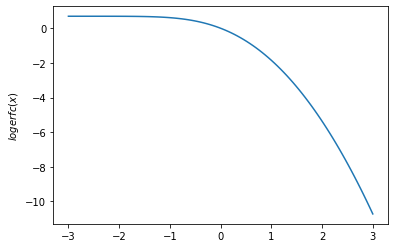

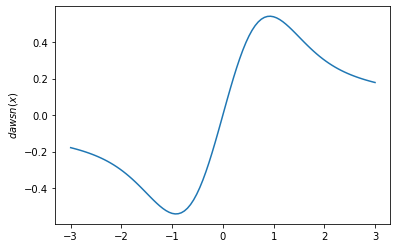

In [ ]:
x = np.linspace(-3., 3., 100)
plt.plot(x, tfp.math.erfcx(x))
plt.ylabel('$erfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfcx(x))
plt.ylabel('$logerfcx(x)$')
plt.show()

plt.plot(x, tfp.math.logerfc(x))
plt.ylabel('$logerfc(x)$')
plt.show()

plt.plot(x, tfp.math.dawsn(x))
plt.ylabel('$dawsn(x)$')
plt.show()

### igammainv /  igammacinv

In [ ]:
# Igammainv and Igammacinv are inverses to Igamma and Igammac

x = np.linspace(1., 10., 10)
y = tf.math.igamma(0.3, x)
x_prime = tfp.math.igammainv(0.3, y)
print('x: {}'.format(x))
print('igammainv(igamma(a, x)):\n {}'.format(x_prime))

y = tf.math.igammac(0.3, x)
x_prime = tfp.math.igammacinv(0.3, y)

print('\n')
print('x: {}'.format(x))
print('igammacinv(igammac(a, x)):\n {}'.format(x_prime))

x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammainv(igamma(a, x)):
 [1.        1.9999992 3.000003  4.0000024 5.0000257 5.999887  7.0002484
 7.999243  8.99872   9.994673 ]


x: [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
igammacinv(igammac(a, x)):
 [1.       2.       3.       4.       5.       6.       7.       8.000001
 9.       9.999999]


### 对数 kve

Text(0.5, 1.0, 'Log(BesselKve(v, x)')

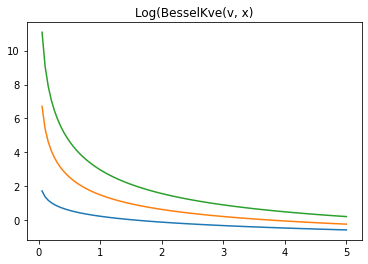

In [ ]:
x = np.linspace(0., 5., 100)
for v in [0.5, 2., 3]:
  plt.plot(x, tfp.math.log_bessel_kve(v, x).numpy())

plt.title('Log(BesselKve(v, x)')

## 其他

- STS

    - 使用内部 `tf.function` 包装加速 STS 预测和分解。
    - 增加一个选项，当只需要最后一步的结果时，可加速 `LinearGaussianSSM` 中的滤波。
    - 具有联合分布的变分推断：[带有 Radon 模型的示例笔记本](https://tensorflow.google.cn/probability/examples/Variational_Inference_and_Joint_Distributions)。
    - 实验性地支持将任何分布转换为预处理双射函数。

- 增加 `tfp.random.sanitize_seed`。

- 增加 `tfp.random.spherical_uniform`。


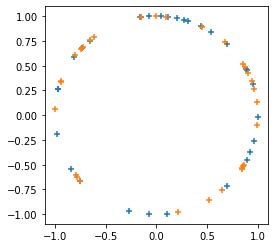

In [64]:
plt.figure(figsize=(4, 4))
seed = tfp.random.sanitize_seed(123)
seed1, seed2 = tfp.random.split_seed(seed)
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed1)
plt.scatter(*samps.numpy().T, marker='+')
samps = tfp.random.spherical_uniform([30], dimension=2, seed=seed2)
plt.scatter(*samps.numpy().T, marker='+');